In [205]:
#Importing the librairies

import numpy as np
import matplotlib.pyplot as plt
import random
try:
    import importlib
    importlib.reload(h)
    importlib.reload(f)
    importlib.reload(d)
except NameError: # It hasn't been imported yet
    import helpers as h
    import implementations as f
    import data_processing as d

# Data preprocessing and feature selections

## Data preprocessing

To open the data, the data folder needs to be one level above the project folder and the data-dontaining folder needs to be named 'data'. The data folder should contain the following files:
- 'x_train.csv'
- 'y_train.csv'
- 'x_test.csv'

#For this to work, the data folder needs to be one level above the project folder and the folder name needs
#to be 'data'
data_folder = '../data/'
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data(data_folder)


In [2]:
np.random.seed(0)

In [3]:
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data("../data")

In [4]:
#Saving the generated arrays in .npy files in order to have faster access to them

np.save('../data/y_train.npy', y_train)
np.save('../data/x_train.npy', x_train)
np.save('../data/x_test.npy', x_test)
np.save('../data/train_ids.npy', train_ids)
np.save('../data/test_ids.npy', test_ids)

In [3]:
#Loading the arrays from the .npy files

x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [ ]:
#Generates the features names

features_name = np.genfromtxt('../data/x_train.csv', delimiter=',', dtype=str, max_rows=1)[1:] 

## Features selection

The original data contains 321 features, but the majority of them are not useful for the prediction. Therefore, we need to select the features that are useful for the prediction. The American Heart Association (AHA) identifies a range of risk factors for heart disease, including:
- Tobacco and alcohol use
- Physical inactivity
- Nutrution
- Obesity & overweight
- Blood cholesterol
- Diabetes
- Blood pressure

and some factors having an influence on the risk factors as : 
- Age
- Income 
- Education
- Gender
- Access and affordability of health care

To represent these factors, the following 21 features were selected:

- GENHLTH: General health condition
- MENTHLTH: Number of days with mental health not good
- PHYSHLTH: Number of days with physical health not good
- HLTHPLN1 : Health care coverage
- MEDCOST : Delayed medical treatment due to costs
- TOLDHI2 : High blood cholesterol
- CVDSTRK3 : Ever told you had a stroke
- DIABETE3 : Ever told you had diabetes
- SEX : Gender of the respondent
- EDUCA : Level of education
- INCOME2 : Annual household income
- DIFFWALK : Difficulty walking
- SMOKE100 : Smoked at least 100 cigarettes in life
- _RFHYPE5 : High blood pressure
- _CHOLCHK : Checked cholesterol within the last 5 years
- _AGEG5YR : Age group
- _BMI5 : Body mass index
- _TOTINDA : Physical activity
- _FRTLT1 : Fruit consumption
- _VEGLT1 : Vegetable consumption
- _RFDRHV5 : Heavy drinking



In [6]:
#Select the important features
features_list = ['_RFHYPE5', 'TOLDHI2', '_CHOLCHK', '_BMI5', 'SMOKE100', 'CVDSTRK3', 'DIABETE3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 
                 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 'SEX', '_AGEG5YR', 'EDUCA', 'INCOME2', ]


In [7]:
trainMask, testMask = f.masking((x_train, x_test), features_name, features_list)
trainProcessed = d.feature_processing_test(trainMask)

#Test data Processing 
testProcessed  = d.feature_processing_test(testMask)


x_train_algo = f.replaceMissingValuesMean(trainMask)
x_test_algo = f.replaceMissingValuesMean(testMask)

yo
328135


In [ ]:
##test chelou
#x1_stand=f.standardize(x_train_algo)
#x_train_stand=np.ones(x_train_algo.shape)
#x_test_stand=np.ones(x_test_algo.shape)

#x_train_stand=f.standardize(x_train_algo)

#for i in range(len(features_list)):
#  x_train_stand[i]=f.standardize(x_train_algo[i])
#  x_test_stand[i]=f.standardize(x_test_algo[i])

#print(x_trai_stand==x_train_stand)

In [9]:
heart_dis = x_train_algo[y_train == 1]
non_hd = x_train_algo[y_train == -1]
print(len(non_hd))
print(len(heart_dis))

random_indices_nonhd = np.random.choice(range(len(non_hd)), len(heart_dis), replace=False)

train_sample = np.concatenate((heart_dis, non_hd[random_indices_nonhd]), axis=0)
train_sample.shape

299160
28975


(57950, 21)

In [10]:
y_train_sample = np.concatenate((np.ones(len(heart_dis)), -np.ones(len(heart_dis))), axis=0)

#shuffle both train_sample and y_train_sample the same way

shuffle_indices = np.random.permutation(len(train_sample))
train_sample = train_sample[shuffle_indices]
y_train_sample = y_train_sample[shuffle_indices]

print(train_sample.shape, y_train_sample.shape)

(57950, 21) (57950,)


# Processing [Necessary] 
### We want to clean the data for each feature, making them binary for yes/no, etc... and rename them

In [7]:
X = [x_train, x_test]
print(x_train.shape)

for i,x in enumerate(X): 
    x = d.masking(x, features_name,features_list)
    x = d.feature_processing_test(x)
    x = d.replace_nan_mean_column(x)
    X[i] = x


x_train_algo, x_test_algo = X[0], X[1]

(328135, 321)


In [8]:
trainMask, testMask = d.masking((x_train, x_test),features features_list)
trainProcessed = d.feature_processing_test(trainMask)

#Test data Processing 
testProcessed  = d.feature_processing_test(testMask)

x_train_algo = f.replaceMissingValuesMean(trainProcessed)
x_test_algo = f.replaceMissingValuesMean(testProcessed)
print(x_train_algo[:,19])
print(len(x_train_algo))
print(len(features_list))


TypeError: masking() missing 1 required positional argument: 'features_list'

In [9]:
##test chelou
#x1_stand=f.standardize(x_train_algo)
x_train_stand=np.ones(x_train_algo.shape)
x_test_stand=np.ones(x_test_algo.shape)

x_trai_stand=f.standardize(x_train_algo)

for i in range(len(features_list)):
  x_train_stand[i]=f.standardize(x_train_algo[i])
  x_test_stand[i]=f.standardize(x_test_algo[i])

print(x_trai_stand==x_train_stand)



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


### Now that the preprocessing has been done, we can format the data to be used by the algorithms

In [10]:
tX_train = np.c_[np.ones((len(train_sample), 1)), train_sample]
tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_algo]

### Initialisation of set parameters

In [11]:
initial_w = [random.choice([1, -1]) for i in range(len(tX_train[0]))]
max_iter = 500

### Separation of the dataset in a test/train set

In [103]:
#tX_train_train = tX_train[:int(len(tX_train)*0.7)]
#y_train_train = y_train_sample[:int(len(tX_train)*0.7)]
#tX_train_validation = tX_train[int(len(tX_train)*0.7):]
#y_train_validation = y_train_sample[int(len(tX_train)*0.7):]

split=int((len(tX_train))*0.6)
tX_train_train, tX_train_validation = np.split(tX_train,[split])
y_train_train, y_train_validation = np.split(y_train_sample,[split])


## Plotting functions

In [35]:
def loss_progression(w):
    # Plot progression of the weights in function of the iteration and progression on the test set
    plt.figure(0)
    plt.plot(w)

## And then, we can run the algorithms

1. MSE gradient descent

In [120]:
tX_train_neg = tX_train_train[y_train_train == -1]
tX_train_pos = tX_train_train[y_train_train == 1]

y_train_neg = y_train_train[y_train_train == -1]
y_train_pos = y_train_train[y_train_train == 1]

tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)),:]
y_train_neg_red = y_train_neg[:int(len(tX_train_pos))]

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))

We try several weights for gamma to see which one is the best

In [123]:
#Compute gradient descent with MSE as loss function (see functions.py for the function)

w_mse_gd, loss_mse_gd = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 2000, 0.005)
print(loss_mse_gd)

Gradient Descent(1999/2000): Final loss=0.3873215468557408
[38.98634435 27.00502941 20.68981562 ...  0.38745794  0.3873897
  0.38732155]


In [124]:
loss_test_set = []
for w in w_mse_gd:
    loss_test_set.append(f.compute_mse(y_train_validation, tX_train_validation, w))

print(loss_test_set)

[39.55184961408548, 27.28003466872681, 20.882837885353428, 17.071232755536695, 14.674927350221285, 13.057931529932821, 11.889699694543244, 10.985019240962032, 10.242775598875882, 9.60614529662843, 9.043023423209533, 8.534727530037902, 8.070026672346879, 7.641821126709142, 7.245342556540249, 6.877160557911301, 6.534636472084351, 6.215619646074962, 5.918277161583506, 5.640996699085751, 5.382329809481112, 5.140957598356995, 4.915668972323869, 4.705346019086587, 4.508953523208213, 4.325530949933845, 4.154185962015145, 3.9940889385437535, 3.8444681889421837, 3.7046056803198137, 3.5738331668060286, 3.451528649574151, 3.3371131194847763, 3.2300475480116475, 3.129830100475999, 3.035993550897054, 2.9481028812533014, 2.8657530503693605, 2.7885669194133853, 2.716193322351541, 2.648305270801306, 2.5845982836396213, 2.52478883250761, 2.468612895043725, 2.4158246082932497, 2.366195015298414, 2.319510898380014, 2.275573693085604, 2.234198477206367, 2.1952130296589676, 2.15845695439335, 2.123780864825

Text(0.5, 0.98, 'Loss of train and validation test')

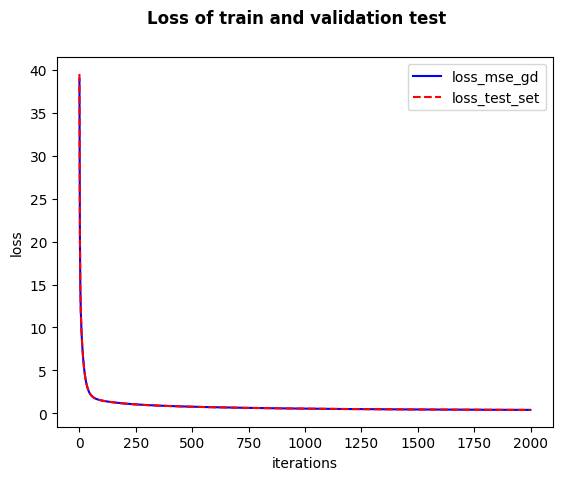

In [137]:
fig, ax = plt.subplots()
ax.semilogy(loss_mse_gd, '-b', label='loss_mse_gd')
ax.semilogy(loss_test_set, '--r', label='loss_test_set')
leg = ax.legend(frameon=True)
plt.xlabel('iterations')
plt.ylabel('loss')
fig.suptitle('Loss of train and validation test', fontweight='bold')

In [109]:
w_mse_gd, loss_mse_gd = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 2000, 0.0001)

Gradient Descent(1999/2000): Final loss=1.4674265115330645


We compare the progression of the loss on the test set, in order to ensure there's no overfitting with the increasing amount of iteration

In [37]:
plt.figure(0)
plt.semilogy(loss_mse_gd)
plt.semilogy(loss_test_set)
plt.show()

KeyboardInterrupt: 

In [113]:
y_pred = tX_train_test.dot(w_mse_gd[-1, :])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))
print("F1 score: ", f1)


Accuracy:  0.6268913709296479
F1 score:  0.13157894736842105


In [ ]:
#h.create_csv_submission(test_ids, y_test_rounded, 'submission_gd.csv')

In [20]:
#Test the model on the test sample. Do we need to standardize ?

y_test = tX_test.dot(w_mse_gd[-1, :])
y_test_rounded = np.where(y_test > 0, 1, -1) 

print('weights = \n\n', w_mse_gd[-1, :],'\n\n Loss = ', loss_mse_gd[-1],'\n\n*****************************************************************************',
      ' \n\n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded == 1)/len(y_test_rounded))

weights = 

 [ 0.82052074  0.51647901 -0.01211363 -0.04327539 -0.03119055  0.8392515
 -0.13274209 -0.18239869  0.6029245  -0.08410116 -0.75144129 -0.03173876
  0.81031081 -0.1046543  -0.15782911  0.87584787 -0.26219147 -0.05150856
 -0.16369252  0.86284716  0.91663502  0.92029775] 

 Loss =  1.4674265115330645 

*****************************************************************************  

 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.33970871922398266


Lets run some cross validation to see the best initial weights (as a function of the proportion of 1, -1 and 0)


2. MSE SGD

SGD iter. 999/999: loss=3.306558108156385, w0=0.8604755895930409, w1=0.6512128038603168
0.000100: 3.306558
SGD iter. 999/999: loss=3.3080137979486626, w0=0.8290158203578314, w1=0.578685159656784
0.000200: 3.308014
SGD iter. 999/999: loss=1.3312468841089882, w0=0.8097731391712423, w1=0.49380818536739407
0.000300: 1.331247
SGD iter. 999/999: loss=0.03486947771508358, w0=0.7816746356501428, w1=0.3877466589186048
0.000400: 0.034869
SGD iter. 999/999: loss=0.025592117522220813, w0=0.7805988454565711, w1=0.41429298561130984
0.000500: 0.025592
SGD iter. 999/999: loss=0.2365302423353723, w0=0.7699343407704058, w1=0.28190237561905196
0.000600: 0.236530
SGD iter. 999/999: loss=0.5720872040185334, w0=0.7579913822485901, w1=0.24679046896912107
0.000700: 0.572087
SGD iter. 999/999: loss=0.1631443056055404, w0=0.7320913144139969, w1=0.14649664897267425
0.000800: 0.163144
SGD iter. 999/999: loss=1.0173639358951578, w0=0.7492368780507389, w1=0.15713367505889175
0.000900: 1.017364
SGD iter. 999/999: lo

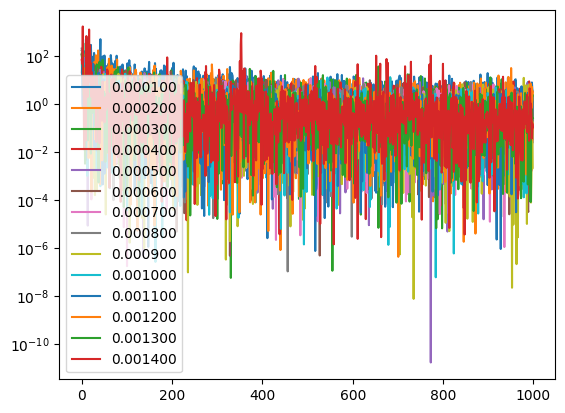

In [115]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(0.0001, 0.0015, 0.0001)
g_opti = gamma[0]
loss_opti = 1000
for g in gamma:
    w, loss = f.mean_squared_error_sgd(y_train_train_reduced, tX_train_train_reduced, initial_w, 1000, g)
    mean_loss = np.mean(loss[-100:])
    if mean_loss < loss_opti:
        loss_opti = mean_loss
        g_opti = g
    print("%f: %f" % (g, loss[-1]))
    plt.semilogy(loss, label = "%f" % g)

    for w in weights:
        loss_test_set.append(f.compute_mse(y, x, w))

    plt.figure(0)
    plt.semilogy(loss)
    plt.semilogy(loss_test_set)
    plt.ylabel("loss")
    plt.xlabel("iterations")
    plt.title("??",fontweight='bold')
    plt.show()


In [220]:
w_mse_sgd, loss_mse_sgd = f.mean_squared_error_sgd(y_train_train_reduced, tX_train_train_reduced, initial_w, 8000, 0.001)

SGD iter. 7999/7999: loss=0.24174221117884592, w0=0.5842168939869486, w1=0.15200134317775804


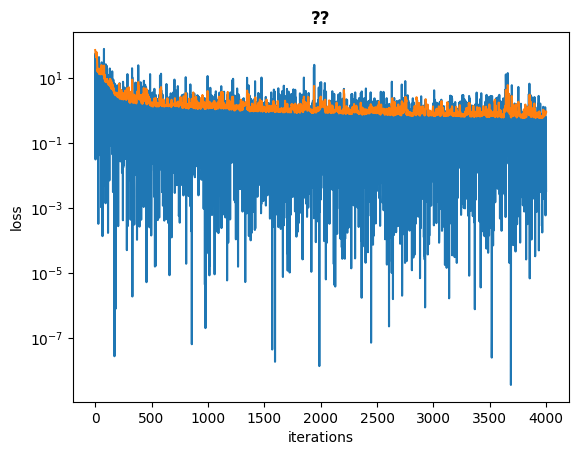

In [222]:
plotLossMSE(w_mse_sgd, loss_mse_sgd, y_train_validation, tX_train_validation)

In [229]:
y_pred = tX_train_test.dot(w_mse_sgd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.5965684855318695
F1 score:  0.23497457235321312


In [230]:
y_test_sgd = tX_test.dot(w_mse_sgd[-1])
y_test_rounded_sgd = np.where(y_test_sgd > 0, 1, -1)

print('weights = \n', w_mse_sgd[-1],'\n Loss = ', loss_mse_sgd[-1],'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded_sgd == 1)/len(y_test_rounded_sgd))

weights = 
 [ 0.58421689  0.15200134 -0.04123393 -0.06149277 -0.14796652 -0.22504104
 -0.13450401 -0.4810878  -0.10478361 -0.31004641 -0.06480837 -0.00552424
 -0.26113397  0.01330946 -0.09038159  0.5227988   0.10294684 -0.12549965
 -0.31492912 -0.10795662  0.2951786  -0.06925756] 
 Loss =  0.24174221117884592 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.4331453021146655


3. Least squares

In [25]:
w_ls, loss_ls = f.least_squares(y_train_train, tX_train_train)

In [26]:
#split the train data with 50/50 label
tX_train_neg = tX_train_train[y_train_train == -1]
tX_train_pos = tX_train_train[y_train_train == 1]
print(len(tX_train_neg), len(tX_train_pos))

y_train_neg = y_train_train[y_train_train == -1]
y_train_pos = y_train_train[y_train_train == 1]

tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)*2),:]
y_train_neg_red = y_train_neg[:int(len(tX_train_pos)*2)]

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))


239400 23108


In [268]:
w_ls, loss_ls = f.least_squares(y_train_train_reduced, tX_train_train_reduced)

In [269]:
y_pred = tX_train_test.dot(w_ls)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.847181800173709
F1 score:  0.40744460856720827


In [270]:

y_test_ls = tX_test.dot(w_ls)
y_test_ls = np.where(y_test_ls > 0, 1, -1)

print('weights = \n', w_ls,'\n Loss = ', loss_ls,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ls == 1)/len(y_test_ls))

weights = 
 [-0.10611158  0.14687807  0.00219303  0.00057961 -0.05586303 -0.04311655
 -0.21873145 -0.42730446 -0.07680913 -0.23363501 -0.00521877 -0.01551829
 -0.1589707  -0.10743765 -0.19060592  0.12411767  0.05531594 -0.35594212
  0.07279247 -0.00920733 -0.00938488 -0.00961666] 
 Loss =  0.3005152511190173 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.16730816701560627


In [271]:
h.create_csv_submission(test_ids, y_test_ls, 'submission_ls.csv')

4. Ridge regression

In [272]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(5*10**(-7), 1*10**(-6), 1*10**(-7))
#gamma = [44,12,3, 0.1, 5*10**(-7)]
g_opti = gamma[0]
loss_opti = 1000
for g in gamma:
    w_ridge, loss_ridge = f.ridge_regression(y_train_train, tX_train_train, g)
    if loss_ridge < loss_opti:
        loss_opti = loss_ridge
        g_opti = g
    print("%e: %f" % (g, loss_ridge))
    #plt.semilogy(loss_ridge, label = "%f" % g)

print("optimal gamma: %.e " % g_opti)
#plt.legend()
#plt.show()


5.000000e-07: 0.136931
6.000000e-07: 0.136931
7.000000e-07: 0.136931
8.000000e-07: 0.136931
9.000000e-07: 0.136931
optimal gamma: 5e-07 


In [273]:
w_ridge, loss_ridge = f.ridge_regression(y_train_train_reduced, tX_train_train_reduced, 5*10**(-7))

In [274]:
y_pred = tX_train_test.dot(w_ridge)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.847181800173709
F1 score:  0.40744460856720827


In [275]:
y_test_ridge = tX_test.dot(w_ridge)
y_test_ridge = np.where(y_test_ridge > 0, 1, -1)

print('weights = \n', w_ridge,'\n Loss = ', loss_ridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ridge == 1)/len(y_test_ridge))

weights = 
 [-0.10613361  0.14687717  0.00219309  0.0005796  -0.05586355 -0.0431167
 -0.21873064 -0.42730059 -0.0768086  -0.23363393 -0.00521922 -0.01551847
 -0.15896918 -0.10743785 -0.19060428  0.12411468  0.05531626 -0.35585239
  0.07278767 -0.00920792 -0.0093849  -0.0096176 ] 
 Loss =  0.3005152511355313 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.16729902449281855


In [98]:
h.create_csv_submission(test_ids, y_test_ridge, 'submission_ridge.csv')

5. Logistic regression

In [276]:
tX_train_neg = tX_train_train[y_train_train == -1]
tX_train_pos = tX_train_train[y_train_train == 1]

y_train_neg = y_train_train[y_train_train == -1]
y_train_pos = y_train_train[y_train_train == 1]

tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)*2),:]
y_train_neg_red = y_train_neg[:int(len(tX_train_pos)*2)]

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))

In [277]:
y_train_processed_logreg = np.where(y_train == 1, 1, 0)
y_train_train_lg = np.where(y_train_train_reduced == 1, 1, 0)
y_train_test_lg = np.where(y_train_test == 1, 1, 0)
initial_w = [random.choice([1, 0]) for i in range(len(tX_train[0]))]
#transform initial_w as an array
initial_w = np.array(initial_w)

Gradient Descent(99/99): loss=1.07202471013704, w0=0.6953270683986862, w1=0.11245039101734115
1.000000e-01: 1.072025
Gradient Descent(99/99): loss=1.1631858924945184, w0=0.6841248307921641, w1=0.1511586430325708
1.100000e-01: 1.163186
Gradient Descent(99/99): loss=1.2570036773475215, w0=0.6745429380998622, w1=0.19034558330095805
1.200000e-01: 1.257004
Gradient Descent(99/99): loss=1.3516891197726268, w0=0.6639140929675429, w1=0.23027371689012946
1.300000e-01: 1.351689
Gradient Descent(99/99): loss=1.7457670236277165, w0=0.6939268654007595, w1=0.3932708529430052
1.400000e-01: 1.745767
Gradient Descent(99/99): loss=1.8672630726873471, w0=0.6881672546906757, w1=0.4445545379804773
1.500000e-01: 1.867263
Gradient Descent(99/99): loss=1.9877155613313944, w0=0.6810754940286541, w1=0.493745165399771
1.600000e-01: 1.987716
Gradient Descent(99/99): loss=2.1081813086883576, w0=0.6739619796228917, w1=0.5424106377563742
1.700000e-01: 2.108181
Gradient Descent(99/99): loss=2.2289066529691515, w0=0.6

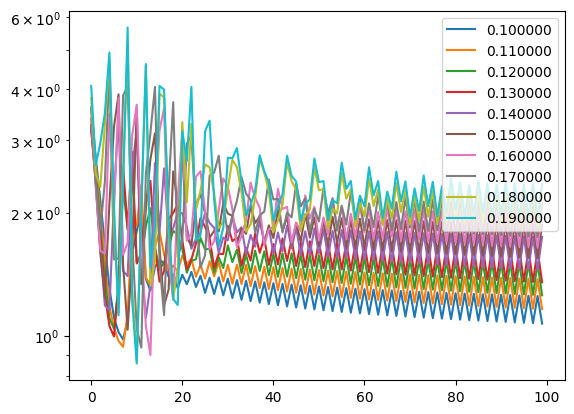

In [279]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = np.arange(10*10**(-2), 20*10**(-2), 1*10**(-2))
#gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
g_opti = gamma[0]
loss_opti = 1000
for g in gamma:
    w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train_train_reduced, initial_w, 100, g)
    if np.mean(loss_logreg[-10:]) < loss_opti:
        loss_opti = np.mean(loss_logreg[-10:])
        g_opti = g
    print("%e: %f" % (g, loss_logreg[-1]))
    plt.semilogy(loss_logreg, label = "%f" % g)

print("optimal gamma: %e " % g_opti)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

In [282]:
w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train_train_reduced,initial_w, 1000, 0.1)

Accuracy:  0.7395455852746621
F1 score:  0.782767223181731


In [41]:
def plotLossLOGREG(weights, loss, y, x ):
    loss_test_set = []

    for w in weights:
        loss_test_set.append(f.compute_loss_logistic(y, x, w))

    plt.figure(0)
    plt.semilogy(loss, label = "initial_loss")
    plt.semilogy(loss_test_set, label = "test_loss")
    plt.legend()
    plt.show()

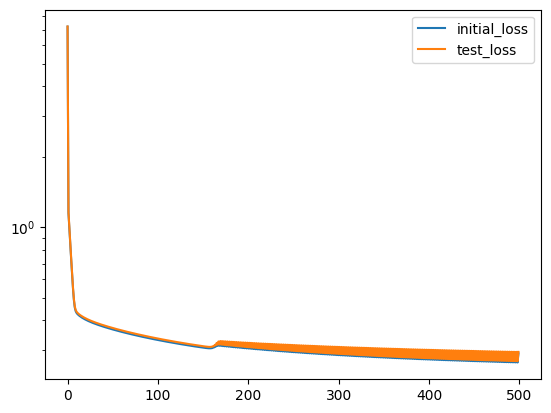

In [42]:
plotLossLOGREG(w_logreg, loss_logreg, y_train_test_lg, tX_train_test)

In [283]:
y_pred = tX_train_test.dot(w_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.9090770566992245
F1 score:  0.1928851616393886


In [284]:
y_test_logreg = tX_test.dot(w_logreg[-1, :])
y_test_logreg = np.where(y_test_logreg > 0.5, 1, 0)

print('weights = \n', w_logreg[-1,:],'\n Loss = ', loss_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train== 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_logreg == 1)/len(y_test_logreg))

weights = 
 [ 0.21960356  0.65956829 -0.04164286 -0.0513066  -0.29206735  0.04913939
 -1.18454778 -1.09275646 -0.59314044 -1.382996   -0.27699926 -0.18401414
 -0.98362151 -0.82121437 -1.08942799  0.18428063  0.24536897  0.7374525
 -0.47901103 -0.20085158 -0.16700371  0.08333862] 
 Loss =  0.7971211482965094 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.022591173808500717


In [81]:
y_sub = np.where(y_test_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_logreg.csv')

6. Regularized logistic regression

optimal gamma: 1.000000e-02 
optimal lambda: 1.000000e-01 


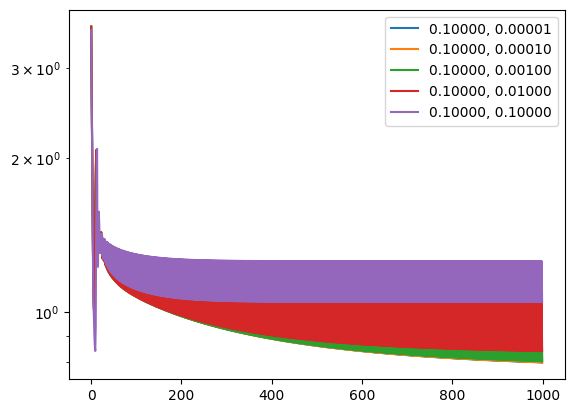

In [285]:
#Try different values of gamma for gradient descent with MSE as loss function
#gamma = np.arange(10*10**(-2), 20*10**(-2), 1*10**(-2))
gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1]
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
g_opti = gamma[0]
l_opti = lambdas[0]
loss_opti = 1000
for l in lambdas:
    for g in gamma:
        w_logreg, loss_logreg = f.reg_logistic_regression(y_train_train_lg, tX_train_train_reduced,l,  initial_w, 1000, g)
        if np.mean(loss_logreg[-10:]) < loss_opti:
            loss_opti = np.mean(loss_logreg[-10:])
            g_opti = g
            l_opti = l
        #print("%e, %e: %f" % (g, l, loss_logreg[-1]))
    plt.semilogy(loss_logreg, label = "%.5f, %.5f" % (g, l) )

print("optimal gamma: %e " % g_opti)
print("optimal lambda: %e " % l_opti)
plt.legend()
plt.show()

In [217]:
w_reg_logreg, loss_reg_logreg = f.reg_logistic_regression(y_train_train_lg, tX_train_train_reduced, l_opti, initial_w, 6000, g_opti)

In [218]:
y_pred = tX_train_test.dot(w_reg_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.8695658798969936
F1 score:  0.37012509197939664


In [219]:
y_test_reg_logreg = tX_test.dot(w_reg_logreg[-1])
y_test_reg_logreg = np.where(y_test_reg_logreg > 0.5, 1, 0)

print('weights = \n', w_reg_logreg[-1],'\n Loss = ', loss_reg_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_reg_logreg == 1)/len(y_test_reg_logreg))


weights = 
 [-0.08528558  0.21019329  0.01909041  0.00178655 -0.04090119 -0.08167134
 -0.26771923 -0.21615422 -0.24112636 -0.2626394  -0.16627398 -0.10377971
 -0.16877567 -0.17122445 -0.27945675  0.03567885  0.18228154 -0.01988684
 -0.06387902 -0.01686432 -0.01034752 -0.01689669] 
 Loss =  0.501688356246266 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.11644831274741953


In [38]:
y_sub = np.where(y_test_reg_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_reg_logreg7.csv')